# CE-40550: Machine Learning for Bioinformatic
## HW5 - Generative Adversarial Networks
#### 34 Points

---

Name: Mahdi Kafi

Student No.: 99210753

---

### 1) Importing Libraries

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline

### 2) Auxiliary Modules
These are some useful modules that you can use. Please read them carefully and use them wherever you need.

In [2]:
class Reshape(nn.Module):
  """
  This module reshapes its input to `new_shape`
  """
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape

  def forward(self, x):
    return x.view(-1, *self.new_shape)

class NoiseGenerator(nn.Module):
  """
  This module generates `n` noises with `z_dim` dim from Normal distribution.
  """
  def __init__(self, z_dim):
    super().__init__()
    self.z_dim = z_dim

  def forward(self, n):
    noise = torch.randn(n, *self.z_dim).to(device)
    return noise

### 3) Helper Functions

In [3]:
def vector_linspace(start, end, steps):
  """
  Vector version of torch linspace
  """
  result = []
  for dim in range(start.shape[0]):
    result.append(torch.linspace(start[dim], end[dim], steps))
  result = torch.stack(result, dim=1).to(device)
  return result
  
def mnist_show(image_batch, rows=1):
  """
  This function gets multiple MNIST images and plots them in the given number of rows.
  """
  image_batch = image_batch.detach().cpu()
  image_batch = image_batch.view(-1, 28, 28)
  image_batch = image_batch.numpy()

  cols = np.ceil(image_batch.shape[0] / rows)
  plt.rcParams['figure.figsize'] = (cols, rows)
  
  for i in range(image_batch.shape[0]):
      plt.subplot(rows, cols, i + 1)
      plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
      plt.axis('off')
  plt.show()

def mnist_visulization_helper_fn(trainer):
  """
  Generates fake samples and plots them for you.
  """
  _, fake_samples = trainer.generate_samples(30)
  mnist_show(fake_samples, 3)

def show_interpolations(trainer, n_rows, n_cols):
    """
    Shows image interpolation (grid of [`n_rows`, `n_cols`]) in input noise space.
    """
    anchor_noises = trainer.noise_generator(4)
    left_column = vector_linspace(anchor_noises[0], anchor_noises[1], n_rows)
    right_column = vector_linspace(anchor_noises[2], anchor_noises[3], n_rows)
    rows = []
    for i in range(n_rows):
      rows.append(vector_linspace(left_column[i], right_column[i], n_cols))
    noises = torch.stack(rows, dim=0).view(n_rows * n_cols, -1)
    with torch.no_grad():
      fake_imgs = trainer.generator(noises)
    mnist_show(fake_imgs, n_rows)

### 4) Importing Dataset

In [4]:
np.random.seed(0)
torch.manual_seed(0)
BATCH_SIZE = 256
device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')


mnist_dataset_kwargs = {
    'download': True,
    'transform': transforms.Compose([
                                     transforms.ToTensor(),
                                     lambda img: img * 2 - 1
                                     ])
}

mnist_dataloader_kwargs = {
    'batch_size': BATCH_SIZE, 
    'pin_memory': True,
    'num_workers': 4,
    'shuffle': True
}

mnist_train_dataset = datasets.MNIST('./data', train=True, **mnist_dataset_kwargs)
mnist_test_dataset = datasets.MNIST('./data', train=False, **mnist_dataset_kwargs)


mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, sampler= None, **mnist_dataloader_kwargs)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, sampler= None, **mnist_dataloader_kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

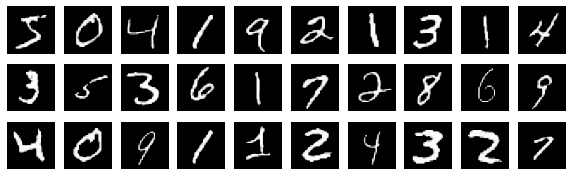

In [5]:
temp = torch.stack([mnist_train_dataset[i][0] for i in range(30)], dim=0)
mnist_show(temp, 3)

### 5) Defining Models (6 points)
In this section you are going to define generator and discriminator models. Also you should define a module to generate noise.

In [6]:
  # Generator part
#################### Problem 16 (3 points) ####################
# 1) Define `mnist_noise_generator`.
# 2) Define `mnist_generator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Tanh` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_noise_generator = NoiseGenerator([100])

mnist_generator = nn.Sequential(
    nn.ConvTranspose2d(in_channels=100, out_channels=256, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=8, stride=2, padding=0),
    nn.Tanh()
)
####################### End ########################

# Discriminator part
#################### Problem 17 (3 points) ####################
# 1) Define `mnist_discriminator` network.
#    Use `LeakyReLU` for intermediate layers.
#    Use `Linear` for the last layer.
#    Use convolution layers.
#    Can use batch norm, dropout, ...
####################################################
mnist_discriminator = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1), 
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4*4*128, out_features=1),
    nn.Sigmoid()
)
####################### End ########################

mnist_generator = mnist_generator.to(device)
mnist_discriminator = mnist_discriminator.to(device)

print(mnist_generator)
print(mnist_discriminator)

Sequential(
  (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): ConvTranspose2d(64, 1, kernel_size=(8, 8), stride=(2, 2))
  (10): Tanh()
)
Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_sl

### 6) Training Loop (14 points)
In this section you are going to complete the training loop structure code.  

In [7]:
class GANTrainer:
  """
  This class wraps the GAN training structure.

  Some arguments:
  `visualization_helper_fn`: Used to visualize model outputs at the end of each epoch.
  `G_loss_mode`: `{"logD" | "log(1-D)"}` Controls the loss function of the `generator`.
  `generator`: The generator.
  `discriminator`: The discriminator. The last layer is a LINEAR layer.
  """
  def __init__(self, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader,
               noise_generator:NoiseGenerator, generator:nn.Module, discriminator:nn.Module,
               G_lr, D_lr,
               visualization_helper_fn, G_loss_mode):
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader

    self.noise_generator = noise_generator.to(device)
    self.generator = generator.to(device)
    self.discriminator = discriminator.to(device)

    self.visualization_helper_fn = visualization_helper_fn
    self.G_loss_mode = G_loss_mode
    
    #################### Problem 01 (1 points) ####################
    # Define Adam optimizers with `G_lr` and `D_lr` learning rates.
    ####################################################
    self.opt_G = optim.Adam(self.generator.parameters(), lr=G_lr)
    self.opt_D = optim.Adam(self.discriminator.parameters(), lr=D_lr)
    ####################### End ########################

  def generate_samples(self, n):
    """
    This function generates `n` samples.
    """
    #################### Problem 02 (1 points) ####################
    # 1) Generate `n` noises
    # 1) Transform noises to samples
    ####################################################
    noise = self.noise_generator(n)
    noise = torch.unsqueeze(noise, dim=-1)
    noise = torch.unsqueeze(noise, dim=-1)
    fake_samples = self.generator(noise.to(device))
    ####################### End ########################
    return noise, fake_samples

  def G_step(self, n):
    """
    This function calculates `generator`'s loss for `n` samples.
    """
    #################### Problem 03 (1 points) ####################
    # 1) Generate `n` fake samples. put them in `x_fake`
    # 2) Compute discriminator `logits` for generated samples
    ####################################################
    x_fake = self.generate_samples(n)[1]
    logits = self.discriminator(x_fake).view(-1)
    ####################### End ########################

    if self.G_loss_mode == 'logD':
      #################### Problem 04 (2 points) ####################
      # Compute the `generator`'s loss when using `logD` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      criterion = nn.BCELoss()
      loss = torch.mean(criterion(logits, torch.full((n,), 1, dtype=torch.float, device=device)))
      ####################### End ########################

    elif self.G_loss_mode == 'log(1-D)':
      #################### Problem 05 (2 points) ####################
      # Compute the `generator`'s loss when using `log(1-D)` as an objective.
      # `loss = mean(...)`
      #
      # CAUTION!!!!! --->>>> PAY ATTENTION TO THE SIGN OF LOSS
      ####################################################
      criterion = nn.BCELoss()
      loss = torch.mean(-criterion(logits, torch.full((n, ), 0, dtype=torch.float, device=device)))
      ####################### End ########################

    else:
      raise BaseException('Invalid generator train mode!!')
      
    return loss, x_fake

  def D_step(self, x_real):
    """
    This function calculates `discriminator`'s loss for `x_real` and `x_fake`.
    """
    #################### Problem 06 (1 points) ####################
    # 1) Generate `n` fake samples. n is equal to length of real samples
    #  put them in `x_fake`
    # 2) Detach the generated samples.
    ####################################################
    x_fake = self.generate_samples(x_real.shape[0])[1].detach()
    ####################### End ########################

    #################### Problem 07 (2 points) ####################
    # Compute discriminator `loss` for `x_real` and `x_fake`. 
    # `loss = mean(...)`
    ####################################################
    criterion = nn.BCELoss()
    loss_real = torch.mean(criterion(self.discriminator(x_real).view(-1), torch.full((x_real.shape[0],), 1, dtype=torch.float, device=device)))
    loss_fake = torch.mean(criterion(self.discriminator(x_fake).view(-1), torch.full((x_real.shape[0],), 0, dtype=torch.float, device=device)))
    loss = loss_real + loss_fake
    ####################### End ########################

    return loss

  def train_loop(self, epoch, G_update_times, D_update_times):
    """
    This function iterates over `train_dataloader` and trains 
    `generator` and `discriminator` for ONE epoch.

    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    train_G_loss = 0
    train_D_loss = 0

    for batch_idx, (x, _) in enumerate(tqdm(self.train_dataloader)):
      x = x.to(device)

      for _ in range(D_update_times):
        #################### Problem 08 (1 points) ####################
        # 1) Put `generator` and `discriminator` in appropriate mode
        # 2) Zero out `opt_D`'s gradients
        # 3) Compute `discriminator`'s loss (`D_loss`); use `D_step`
        # 4) Backpropagate `D_loss`
        # 5) Update ``discriminator` parameters
        ####################################################
        self.discriminator.train()
        self.generator.eval()
        self.opt_D.zero_grad()
        D_loss = self.D_step(x)
        D_loss.backward()
        self.opt_D.step()
        ####################### End ########################

      for _ in range(G_update_times):
        #################### Problem 09 (1 points) ####################
        # 1) Put `generator` and `discriminator` in appropriate mode
        # 2) Zero out `opt_G`'s gradients
        # 3) Compute `generator`'s loss (`G_loss`); use `G_step`
        # 4) Backpropagate `G_loss`
        # 5) Update `generator` parameters
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        self.generator.zero_grad()
        G_loss = self.G_step(x.shape[0])[0]
        G_loss.backward()
        self.opt_G.step()
        ####################### End ########################
      
      train_D_loss += D_loss.item() * x.shape[0]
      train_G_loss += G_loss.item() * x.shape[0]

      if batch_idx % LOG_INTERVAL == 0:
          print('Train | Epoch: {} [{}/{}]\t\tD-Loss: {:.6f}\tG-Loss: {:.6f}'
          .format(epoch, batch_idx * len(x), len(self.train_dataloader) * BATCH_SIZE, D_loss, G_loss))

    train_D_loss /= len(self.train_dataloader) * BATCH_SIZE
    train_G_loss /= len(self.train_dataloader) * BATCH_SIZE
    
    print('====> Train | Epoch: {} \t | \tAverage D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(epoch, train_D_loss, train_G_loss,))
    return train_G_loss, train_D_loss
  
  def test(self):
    """
    This function iterates over `test_dataloader` and
    reports `generator` and `discriminator` losses.
    """
    self.discriminator.eval()
    self.generator.eval()

    test_G_loss = 0
    test_D_loss = 0

    with torch.no_grad():
      for x, _ in self.test_dataloader:
        x = x.to(device)

        #################### Problem 10 (1 points) ####################
        # 1) Put `generator` in `eval` mode
        # 2) Put `discriminator` in `train` mode
        # 4) Compute `discriminator`'s loss; use `D_step`
        ####################################################
        self.generator.eval()
        self.discriminator.train()
        D_loss = self.D_step(x)
        ####################### End ########################

        #################### Problem 11 (1 points) ####################
        # 1) Put `generator` in `train` mode
        # 2) Put `discriminator` in `eval` mode
        # 4) Compute `generator`'s loss; use `G_step(n)` where `n = x.shape[0]`
        ####################################################
        self.generator.train()
        self.discriminator.eval()
        G_loss = self.G_step(x.shape[0])[0]
        ####################### End ########################

        test_D_loss += D_loss.item() * x.shape[0]
        test_G_loss += G_loss.item() * x.shape[0]

            
    test_D_loss /= len(self.test_dataloader) * BATCH_SIZE
    test_G_loss /= len(self.test_dataloader) * BATCH_SIZE
    
    print('====> Test | Average D-loss: {:.4f} \t | \tAverage G-loss: {:.4f}'.format(test_D_loss, test_G_loss,))
    return test_G_loss, test_D_loss

  def run(self, n_epoch, G_update_times=1, D_update_times=1):
    """
    This function will optimize parameters of `generator` and `discriminator`
    for `n_epoch` epochs on `train_dataloader` dataset and validate it on
    `test_dataloader`. At the end of each epoch, `visualization_helper_fn`
    will be called to visualize the GAN behavior.


    Some arguments: \n
    `G_update_times`: how many times to update `generator` on each batch \n
    `D_update_times`: how many times to update `discriminator` on each batch \n
    """
    
    for epoch in range(1, n_epoch + 1):
        self.train_loop(epoch, G_update_times, D_update_times)
        self.test()
        self.visualization_helper_fn(self)   


### 7) Run GAN (10 ponits)


In this section, you will train a GAN for mnist dataset. Tune the learning rates for the generator and the discriminator, choose the loss function for the generator network and determine the number of epochs and the generator and discriminator's update times in each epoch.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train | Epoch: 1 [0/60160]		D-Loss: 0.000000	G-Loss: 100.000000
Train | Epoch: 1 [12800/60160]		D-Loss: 0.000000	G-Loss: 100.000000
Train | Epoch: 1 [25600/60160]		D-Loss: 0.000000	G-Loss: 100.000000
Train | Epoch: 1 [38400/60160]		D-Loss: 0.000000	G-Loss: 100.000000
Train | Epoch: 1 [51200/60160]		D-Loss: 0.000000	G-Loss: 100.000000

====> Train | Epoch: 1 	 | 	Average D-loss: 0.0000 	 | 	Average G-loss: 99.7340
====> Test | Average D-loss: 0.0000 	 | 	Average G-loss: 97.6562


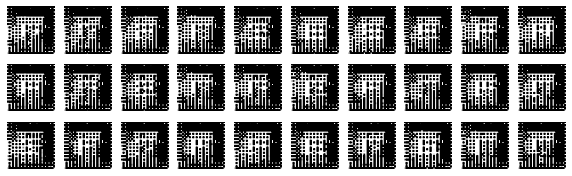

In [17]:
LOG_INTERVAL = 50
#################### Problem 18 (1 points) ####################
# Tune `generator` and `discriminator` learning rates
# and also the `G_LOSS_MODE`.
####################################################
MNIST_G_LEARNING_RATE = 0.01
MNIST_D_LEARNING_RATE = 0.01
G_LOSS_MODE = "logD"
####################### End ########################

mnist_trainer = GANTrainer(mnist_train_dataloader, mnist_test_dataloader,
                           mnist_noise_generator, mnist_generator, mnist_discriminator,
                           MNIST_G_LEARNING_RATE, MNIST_D_LEARNING_RATE,
                           mnist_visulization_helper_fn, G_LOSS_MODE)

#################### Problem 19 (1 points) ####################
# Tune `n_epoch`, `G_update_times` and `D_update_times`
####################################################
mnist_trainer.run(n_epoch=1, G_update_times=10, D_update_times=10)
####################### End ########################

Question 1) What will happen if the number of updates of discriminator network is much higher than the number of updates of generator network in each epoch? (2 points)

Your answer:<br>
<div dir="rtl">
اگر این کار را بکنیم، شبکه تمییزدهنده به سرعت قوی‌تر می‌شود و باعث می‌شود که به راحتی داده‌های تولید شده توسط مولد را به راحتی شناسایی کند و باعث شود که loss مولد کاهش نیابد و نتواند داده‌های خوبی تولید کند.
</div>

Question 2) What will happen if the number of updates of generator network is much higher than the number of updates of discriminator network in each epoch? (2 points)

Your answer:<br>
<div dir="rtl">
در این حالت عکس حالت بالا باعث می‌شود که شبکه مولد بتواند در اوایل آموزش داده‌های نسبتا خوبی تولید کند که شبکه تمییزدهنده نتواند آن‌ها را از داده‌های واقعی تشخیص دهد و این باعث می‌شود که در نهایت نیز داده‌های خروجی شبکه مولد از کیفیت خوبی برخوردار نباشند و فقط می‌توانند شبکه تمییزدهنده را فریب بدهند.
</div>

You can write your answers in persian.

### 8) Final Visualization

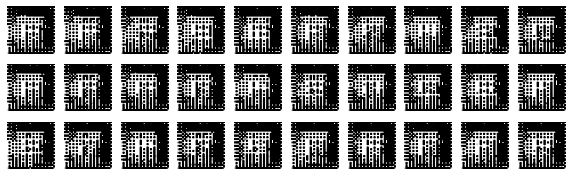

In [18]:
mnist_visulization_helper_fn(mnist_trainer)

### 10) Interpolation (4 points)

In [19]:
show_interpolations(mnist_trainer, 10, 10)

RuntimeError: ignored

Question 3) Describe what is happening above (4 points). You can write your answer in persian.

Your Answer: